In [17]:
from fileData import *
from netEnv import *
from dqnAgent import *
code_path = ".."
requiredFields = ['FileCount', 'AvgFileSize', 'BufSize', 'Bandwidth', 'AvgRtt', 'CC_Level', 'P_Level', 'PP_Level',
                  'numActiveCores', 'frequency', 'TotalAvgTput', 'TotalEnergy', 'DataTransferEnergy']
LabelName = 'TotalAvgTput'
fileData_chameleon = ReadFile(code_path + '/Dataset/Chameleon_Combined_all.csv', requiredFields)

optimal_throughput_dictionary_chameleon = fileData_chameleon.return_map_for_tuple_to_throughput()
filedata_grouped_df = fileData_chameleon.get_grouped_df()
filedata_keys=[key for key, _ in filedata_grouped_df]
a_group=filedata_grouped_df.get_group(filedata_keys[1])
print(len(fileData_chameleon.group_keys))


34


In [18]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

class Network(nn.Module):
    def __init__(self,env):
        super().__init__()
        in_features=int(np.prod(env.obs_shape))
        self.net=nn.Sequential(
            nn.Linear(in_features,1024),
            nn.Tanh(),
#             nn.Linear(1024,512),
#             nn.Tanh(),
            nn.Linear(1024, env.action_space.n))

    def forward(self,x):
         return self.net(x)

    def act(self,obs):
        obs_t=torch.as_tensor(obs,dtype=torch.float32)
        q_values=self(obs_t.unsqueeze(0))
        max_q_index=torch.argmax(q_values,dim=1)[0]
        action=max_q_index.detach().item()

        return action
    
    
class DQNAgent():
    def __init__(self,env,GAMMA=0.01,
                    BATCH_SIZE=512,
                    BUFFER_SIZE=50000,
                    MIN_REPLAY_SIZE=1000,
                    EPSILON_START=1.0,
                    EPSILON_END=0.2,
                    EPSILON_DECAY=100000,
                    TARGET_UPDATE_FREQ=1000,
                    WRITER=writer):
        self.env=env
        self.GAMMA=GAMMA
        self.BATCH_SIZE=BATCH_SIZE
        self.BUFFER_SIZE=BUFFER_SIZE
        self.MIN_REPLAY_SIZE=MIN_REPLAY_SIZE
        self.EPSILON_START=EPSILON_START
        self.EPSILON_DECAY=EPSILON_DECAY
        self.EPSILON_END=EPSILON_END
        self.TARGET_UPDATE_FREQ=TARGET_UPDATE_FREQ
        self.replay_buffer=deque(maxlen=self.BUFFER_SIZE)
        self.WRITER=WRITER
        self.rew_buffer=deque([0.0],maxlen=100)
        self.episode_reward=0.0
        self.online_net=Network(env)
        self.target_net=Network(env)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.key_max_action={}
        for key in range(len(self.env.group_keys)):
            for action in range(self.env.action_space.n):
                obs=self.env.reset_group_specific(key)
                new_obs,rew,done, _ =self.env.step(action)
                if rew == 1:
                    self.key_max_action[key]=action
                    break
        self.optimizer=torch.optim.Adam(self.online_net.parameters(),lr=1e-3)
        self.reward_per_episode=[]
        self.epsilon_per_episode=[]


    def warming_replay_buffer_prioritize(self):
        print("warming up memory with prioritization")
        key_max_action={}
        for key in range(len(self.env.group_keys)):
            print(self.env.action_space.n)
            for action in range(self.env.action_space.n):
                obs=self.env.reset_group_specific(key)
                new_obs,rew,done, _ =self.env.step(action)
                if rew == 1:
                    key_max_action[key]=action
                    break

        for key in range(len(self.env.group_keys)):
            obs=self.env.reset_group_specific(key)
            for action in range(self.env.action_space.n):
                obs,_,_,_=self.env.step(action)
#                 obs=self.env.reset_group_specific(key)
                new_obs,rew,done, _ =self.env.step(key_max_action[key])
                transition=(obs,key_max_action[key],rew,done,new_obs)
                self.replay_buffer.append(transition)
                obs=self.env.reset_group_specific(key)

    
    def training(self,TRAINING_STEPS=2000):
        obs=self.env.reset()
        # for step in itertools.count():
        for step in range(TRAINING_STEPS):
            epsilon=np.interp(step,[0,self.EPSILON_DECAY],[self.EPSILON_START,self.EPSILON_END])
            action=self.online_net.act(obs)
            new_obs,rew,done, _ =self.env.step(action)
            transition= (obs,action,rew,done,new_obs)
            obs=new_obs
            self.episode_reward+=rew
            if done:
                obs=self.env.reset()
                self.rew_buffer.append(self.episode_reward)
                self.WRITER.add_scalar("reward/train", self.episode_reward,step)
                self.reward_per_episode.append(self.episode_reward)
                self.epsilon_per_episode.append(epsilon)
                self.episode_reward=0.0
                print("episode ends")


            #### Satrt gradient Step
            transitions=random.sample(self.replay_buffer, self.BATCH_SIZE)
        #     print(transitions)
            obses=np.asarray([t[0] for t in transitions])
            actions=np.asarray([t[1] for t in transitions])
            rews=np.asarray([t[2] for t in transitions])
            dones=np.asarray([t[3] for t in transitions])
            new_obses=np.asarray([t[4] for t in transitions])

            obses_t=torch.as_tensor(obses,dtype=torch.float32)
            actions_t=torch.as_tensor(actions,dtype=torch.int64).unsqueeze(-1)
            rews_t=torch.as_tensor(rews,dtype=torch.float32).unsqueeze(-1)
            dones_t=torch.as_tensor(dones,dtype=torch.float32).unsqueeze(-1)
            new_obses_t=torch.as_tensor(new_obses,dtype=torch.float32)

            #compute Targets
            target_q_values=self.target_net(new_obses_t)
            max_target_q_values=target_q_values.max(dim=1,keepdim=True)[0]
            targets=rews_t+GAMMA *(1-dones_t) * max_target_q_values
#             self.WRITER.add_scalar("target/train", targets, step)

            # Compute Loss
            q_values=self.online_net(obses_t)
            action_q_values=torch.gather(input=q_values,dim=1,index=actions_t)
#             loss=nn.L1Loss(action_q_values,targets)
            loss=nn.functional.smooth_l1_loss(action_q_values,targets)
            self.WRITER.add_scalar("loss/train", loss, step)
            ## Gradient Descent
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # update target network
            if step % self.TARGET_UPDATE_FREQ ==0:
                self.target_net.load_state_dict(self.online_net.state_dict())
            ##logging
            if step %1000 ==0:
                print()
                print('step', step)
                print('Avg Rew',np.mean(self.rew_buffer))
    
    def writer_flush(self):
        self.WRITER.flush()
        self.WRITER.close()
        
    def plot_training_curve(self):
        reward_epsilon_values=[]
        reward_epsilon_values.append(self.reward_per_episode)
        reward_epsilon_values.append(self.epsilon_per_episode)
        labels = ["reward", "epsilon"]
        fig, axs = plt.subplots(2, sharex=True)
        fig.suptitle('reward-episodes & epsilon-episodes graph DQN for selectedGroup')
        for i,ax in enumerate(axs):
            axs[i].plot(reward_epsilon_values[i],label=labels[i])
            axs[i].legend(loc="lower right")
        plt.show()
    
    def save_model(self):
        name='agent'+str(self.env.environment_group_identification)
        torch.save(self.online_net, name+"online_net")
        torch.save(self.target_net, name+"target_net")

    def load_model(self,online_net,target_net):
        self.online_net = torch.load("online_net")
        self.target_net = torch.load("target_net")

In [20]:
import time
environmentG1=environmentGroups(fileData_chameleon.get_grouped_df(),fileData_chameleon.group_keys[0:8],0)
env=NetEnvironment(environmentG1,fileData_chameleon.group_keys[0:8])
env.reset()
agent=DQNAgent(env,EPSILON_DECAY=100)
t = time.time()
agent.warming_replay_buffer_prioritize()
print(f"warming up time is {time.time()- t} seconds")
t = time.time()
agent.training(TRAINING_STEPS=100000)
print(f"training up time is {time.time()- t} seconds")
agent.writer_flush()

warming up memory with prioritization
139
139
139
139
139
139
139
139
warming up time is 3.5679221153259277 seconds

step 0
Avg Rew 0.0
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 1000
Avg Rew 61.315781888941416
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 2000
Avg Rew 72.40204182954419
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 3000
Avg Rew 75.98102563634474
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 4000
Avg Rew 63.54662913967529
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 5000
Avg Rew 64.81199597503307
episode ends
episode ends
ep

episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 49000
Avg Rew 90.19361480858792
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 50000
Avg Rew 90.1899821835264
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 51000
Avg Rew 91.7049821835264
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 52000
Avg Rew 93.0505991999298
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 53000
Avg Rew 88.77525274832838
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 54000
Avg Rew 82.8442710311656
episode e

episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 98000
Avg Rew 94.28482303068964
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends

step 99000
Avg Rew 96.3938774068799
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
episode ends
training up time is 1954.9761230945587 seconds


In [21]:
len(agent.replay_buffer)

1112

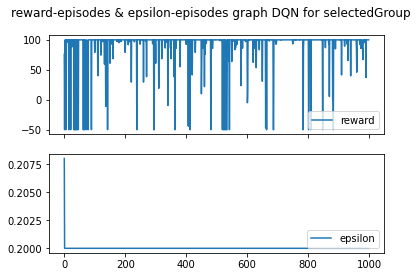

In [22]:
agent.plot_training_curve()

######################################
validating for (32, 35, 40, 10, 30)


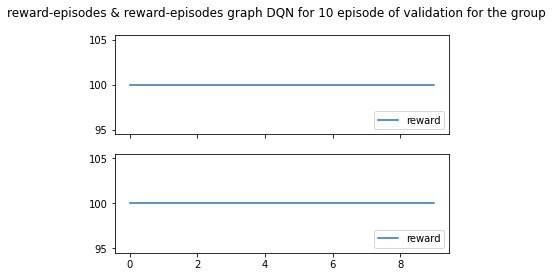

[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
(16, 1, 8)
(16.0, 1.0, 8.0) {0: 27, 1: 27, 2: 34, 3: 88, 4: 68, 5: 69, 6: 69, 7: 99}
#########################################
######################################
validating for (32, 35, 40, 10, 40)


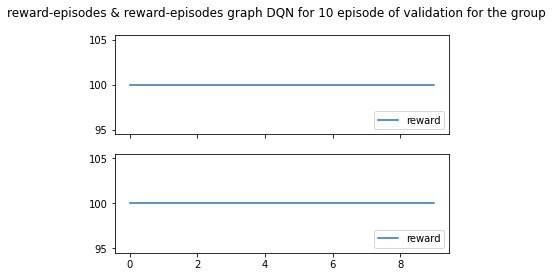

[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
(16, 1, 8)
(16.0, 1.0, 8.0) {0: 27, 1: 27, 2: 34, 3: 88, 4: 68, 5: 69, 6: 69, 7: 99}
#########################################
######################################
validating for (32, 35, 40, 10, 50)


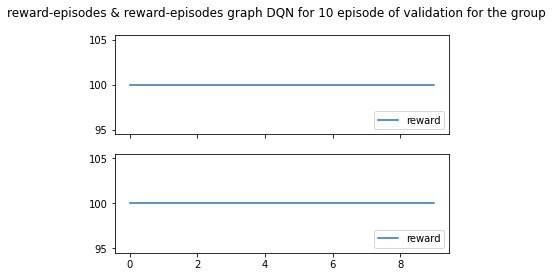

[34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]
(32, 1, 16)
(32.0, 1.0, 16.0) {0: 27, 1: 27, 2: 34, 3: 88, 4: 68, 5: 69, 6: 69, 7: 99}
#########################################
######################################
validating for (32, 223, 40, 10, 30)


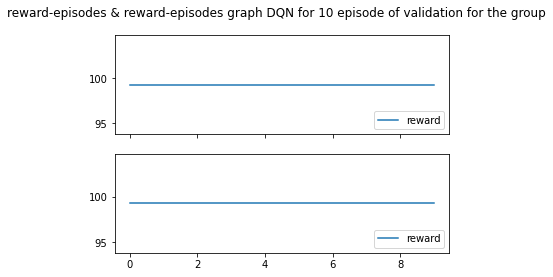

[88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88]
(9, 1, 9)
(19.0, 1.0, 19.0) {0: 27, 1: 27, 2: 34, 3: 88, 4: 68, 5: 69, 6: 69, 7: 99}
#########################################
######################################
validating for (32, 223, 40, 10, 40)


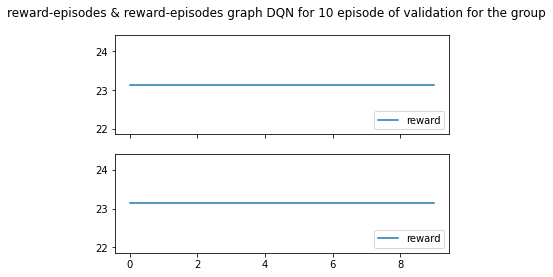

[68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68]
(4, 1, 28)
(9.0, 1.0, 9.0) {0: 27, 1: 27, 2: 34, 3: 88, 4: 68, 5: 69, 6: 69, 7: 99}
#########################################
######################################
validating for (32, 223, 40, 10, 50)


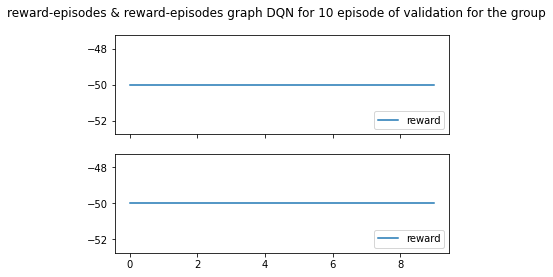

[69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69]
(4, 1, 32)
(9.0, 1.0, 19.0) {0: 27, 1: 27, 2: 34, 3: 88, 4: 68, 5: 69, 6: 69, 7: 99}
#########################################
######################################
validating for (32, 223, 40, 10, 60)


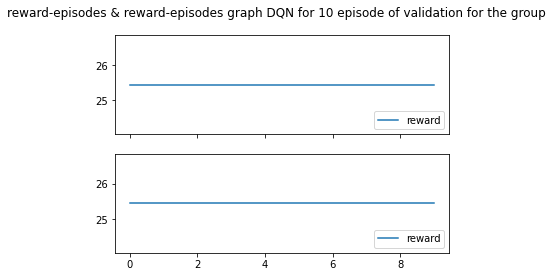

[69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69]
(4, 1, 32)
(9.0, 1.0, 19.0) {0: 27, 1: 27, 2: 34, 3: 88, 4: 68, 5: 69, 6: 69, 7: 99}
#########################################
######################################
validating for (32, 223, 40, 10, 70)


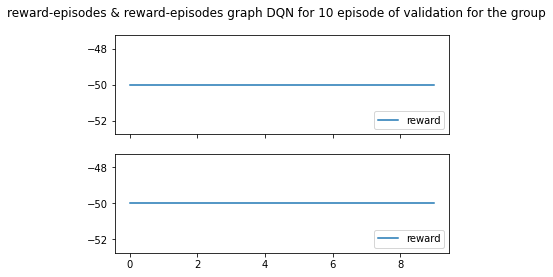

[99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]
(12, 1, 32)
(24.0, 1.0, 1.0) {0: 27, 1: 27, 2: 34, 3: 88, 4: 68, 5: 69, 6: 69, 7: 99}
#########################################


In [23]:
for i in range(0,8):
    print("######################################")
    environmentG1Validation=environmentGroupValidation(fileData_chameleon.get_grouped_df(),fileData_chameleon.group_keys[i])
    env_validation=NetEnvironmentValidation(environmentG1Validation,environmentG1.action_list)
    env_validation.reset()
    reward_per_episode_validation,action_list_per_episode=validation(agent,env_validation)
    reward_epsilon_values=[]
    reward_epsilon_values.append(reward_per_episode_validation)
    reward_epsilon_values.append(reward_per_episode_validation)
    labels = ["reward", "reward"]
    fig, axs = plt.subplots(2, sharex=True)
    fig.suptitle('reward-episodes & reward-episodes graph DQN for 10 episode of validation for the group')
    for i,ax in enumerate(axs):
        axs[i].plot(reward_epsilon_values[i],label=labels[i])
        axs[i].legend(loc="lower right")
    plt.show()
    print(action_list_per_episode[0])
    print(environmentG1.action_list[action_list_per_episode[0][0]])
    print(env_validation.max_throughput_parameters,agent.key_max_action)
    print("#########################################")

In [24]:
agent.replay_buffer

deque([(array([32, 35, 40, 10, 30,  1,  1,  1]),
        27,
        1.0,
        False,
        array([32, 35, 40, 10, 30, 16,  1,  8])),
       (array([32, 35, 40, 10, 30,  1,  1,  2]),
        27,
        1.0,
        False,
        array([32, 35, 40, 10, 30, 16,  1,  8])),
       (array([32, 35, 40, 10, 30,  1,  1,  4]),
        27,
        1.0,
        False,
        array([32, 35, 40, 10, 30, 16,  1,  8])),
       (array([32, 35, 40, 10, 30,  1,  1,  8]),
        27,
        1.0,
        False,
        array([32, 35, 40, 10, 30, 16,  1,  8])),
       (array([32, 35, 40, 10, 30,  1,  1, 16]),
        27,
        1.0,
        False,
        array([32, 35, 40, 10, 30, 16,  1,  8])),
       (array([32, 35, 40, 10, 30,  1,  1, 32]),
        27,
        1.0,
        False,
        array([32, 35, 40, 10, 30, 16,  1,  8])),
       (array([32, 35, 40, 10, 30,  2,  1,  1]),
        27,
        1.0,
        False,
        array([32, 35, 40, 10, 30, 16,  1,  8])),
       (array([32, 35, 40, 

In [35]:
torch.save(agent.online_net, "online_net")
torch.save(agent.target_net, "target_net")

In [7]:
for i in fileData_chameleon.group_keys[0:8]:
    print(i)

(32, 35, 40, 10, 30)
(32, 35, 40, 10, 40)
(32, 35, 40, 10, 50)
(32, 223, 40, 10, 30)
(32, 223, 40, 10, 40)
(32, 223, 40, 10, 50)
(32, 223, 40, 10, 60)
(32, 223, 40, 10, 70)


In [8]:
for key in agent.env.group_keys:
    print(agent.env.environment_group.total_number_of_logs(key))

857
6
1
8247
50
14
11
9


In [ ]:
# ################################
# ###Test agent
# ###############################

# agent=DQNAgent(env,EPSILON_DECAY=1000)
# t = time.time()
# agent.warming_replay_buffer_prioritize()
# print(f"warming up time is {time.time()- t} seconds")

In [ ]:
obs=agent.env.reset()
print(obs)
action=agent.online_net.act(obs)
print(action)
# # for step in itertools.count():
# for step in range(TRAINING_STEPS):
#     epsilon=np.interp(step,[0,self.EPSILON_DECAY],[self.EPSILON_START,self.EPSILON_END])
#     action=self.online_net.act(obs)
#     new_obs,rew,done, _ =self.env.step(action)
#     transition= (obs,action,rew,done,new_obs)
#     obs=new_obs
#     self.episode_reward+=rew
#     if done:
#         obs=self.env.reset()
#         self.rew_buffer.append(self.episode_reward)
#         self.WRITER.add_scalar("reward/train", self.episode_reward,step)
#         self.reward_per_episode.append(self.episode_reward)
#         self.epsilon_per_episode.append(epsilon)
#         self.episode_reward=0.0
#         print("episode ends")


#     #### Satrt gradient Step
#     transitions=random.sample(self.replay_buffer, self.BATCH_SIZE)
# #     print(transitions)
#     obses=np.asarray([t[0] for t in transitions])
#     actions=np.asarray([t[1] for t in transitions])
#     rews=np.asarray([t[2] for t in transitions])
#     dones=np.asarray([t[3] for t in transitions])
#     new_obses=np.asarray([t[4] for t in transitions])

In [ ]:
transitions=random.sample(agent.replay_buffer, agent.BATCH_SIZE)
# print(transitions)
obses=np.asarray([t[0] for t in transitions])
actions=np.asarray([t[1] for t in transitions])
rews=np.asarray([t[2] for t in transitions])
dones=np.asarray([t[3] for t in transitions])
new_obses=np.asarray([t[4] for t in transitions])

print("obses",obses)
print("actions",actions)
obses_t=torch.as_tensor(obses,dtype=torch.float32)
actions_t=torch.as_tensor(actions,dtype=torch.int64).unsqueeze(-1)
rews_t=torch.as_tensor(rews,dtype=torch.float32).unsqueeze(-1)
dones_t=torch.as_tensor(dones,dtype=torch.float32).unsqueeze(-1)
new_obses_t=torch.as_tensor(new_obses,dtype=torch.float32)
print("obses_t",obses_t)
print("actions_t",actions_t)
#compute Targets
target_q_values=agent.target_net(new_obses_t)
print("target_q_values",target_q_values)
print(target_q_values[0])
print(target_q_values[0].shape)
max_target_q_values=target_q_values.max(dim=1,keepdim=True)[0]
targets=rews_t+GAMMA *(1-dones_t) * max_target_q_values
print("targets",targets,targets.shape)
# #             self.WRITER.add_scalar("target/train", targets, step)

# # Compute Loss
# q_values=self.online_net(obses_t)
# action_q_values=torch.gather(input=q_values,dim=1,index=actions_t)
# loss=nn.functional.smooth_l1_loss(action_q_values,targets)



In [28]:
environmentG1.return_global_action_list()

[(1, 1, 1),
 (1, 1, 2),
 (1, 1, 4),
 (1, 1, 8),
 (1, 1, 16),
 (1, 1, 32),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 4),
 (2, 1, 8),
 (2, 1, 16),
 (2, 1, 32),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 4),
 (4, 1, 8),
 (4, 1, 16),
 (4, 1, 32),
 (8, 1, 1),
 (8, 1, 2),
 (8, 1, 4),
 (8, 1, 8),
 (8, 1, 16),
 (8, 1, 32),
 (16, 1, 1),
 (16, 1, 2),
 (16, 1, 4),
 (16, 1, 8),
 (16, 1, 16),
 (16, 1, 32),
 (32, 1, 1),
 (32, 1, 2),
 (32, 1, 4),
 (32, 1, 8),
 (32, 1, 16),
 (32, 1, 32),
 (1, 1, 3),
 (1, 1, 5),
 (1, 1, 9),
 (1, 1, 12),
 (1, 1, 19),
 (1, 1, 20),
 (1, 1, 24),
 (1, 1, 28),
 (1, 1, 31),
 (3, 1, 1),
 (3, 1, 3),
 (3, 1, 5),
 (3, 1, 9),
 (3, 1, 19),
 (3, 1, 31),
 (4, 1, 12),
 (4, 1, 20),
 (4, 1, 24),
 (4, 1, 28),
 (5, 1, 1),
 (5, 1, 3),
 (5, 1, 5),
 (5, 1, 9),
 (5, 1, 19),
 (5, 1, 31),
 (8, 1, 12),
 (8, 1, 20),
 (8, 1, 24),
 (8, 1, 28),
 (9, 1, 1),
 (9, 1, 3),
 (9, 1, 5),
 (9, 1, 9),
 (9, 1, 19),
 (9, 1, 31),
 (12, 1, 1),
 (12, 1, 4),
 (12, 1, 8),
 (12, 1, 12),
 (12, 1, 16),
 (12, 1, 20),
 (12, 1, 24),
 (12, 1, 

In [32]:
environmentG1Validation=environmentGroupValidation(fileData_chameleon.get_grouped_df(),fileData_chameleon.group_keys[7])
print(len(environmentG1.return_global_action_list()))
print(environmentG1.return_global_action_list()[99])
env_validation=NetEnvironmentValidation(environmentG1Validation,environmentG1.action_list)
obs=env_validation.reset()
print(obs)

139
(24, 1, 1)
[ 32 223  40  10  70  16   1  16]


In [33]:
for step in range(0,140):
    env_validation.reset()
    print(env_validation.step(99))

(array([ 32, 223,  40,  10,  70,  16,   1,  16]), -0.5, False, {'time': 1, 'max_time': 100})
(array([ 32, 223,  40,  10,  70,  16,   1,  16]), -0.5, False, {'time': 1, 'max_time': 100})
(array([ 32, 223,  40,  10,  70,  16,   1,  16]), -0.5, False, {'time': 1, 'max_time': 100})
(array([ 32, 223,  40,  10,  70,  16,   1,  16]), -0.5, False, {'time': 1, 'max_time': 100})
(array([ 32, 223,  40,  10,  70,  16,   1,  16]), -0.5, False, {'time': 1, 'max_time': 100})
(array([ 32, 223,  40,  10,  70,  16,   1,  16]), -0.5, False, {'time': 1, 'max_time': 100})
(array([ 32, 223,  40,  10,  70,  16,   1,  16]), -0.5, False, {'time': 1, 'max_time': 100})
(array([ 32, 223,  40,  10,  70,  16,   1,  16]), -0.5, False, {'time': 1, 'max_time': 100})
(array([ 32, 223,  40,  10,  70,  16,   1,  16]), -0.5, False, {'time': 1, 'max_time': 100})
(array([ 32, 223,  40,  10,  70,  16,   1,  16]), -0.5, False, {'time': 1, 'max_time': 100})
(array([ 32, 223,  40,  10,  70,  16,   1,  16]), -0.5, False, {'time'

In [38]:
import time
str(time.strftime("%D-%H:%M:%S",time.localtime()))

'06/15/22-11:49:14'